# Lab - Recommender System


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

/Users/anna-mariasjolund/.local/share/virtualenvs/Machine-learning-Anna-MariaSjolund-8kbAf2Oi/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### 1.1 - Movielens full - EDA
Nu ska du ladda ned datasetet ml-latest.zip under sektionen "recommended for education and
development". Ladda in dataseten "movies.csv" och "ratings.csv" besvara på följande frågor:

a) Gör en EDA för att förstå datasetet. Inkludera olika slags plots. Begränsa dig inte till frågorna nedan,
utan försök undersöka fler aspekter av datan.

In [3]:
movies = pd.read_csv("../../Data/ml-latest/movies.csv")
ratings = pd.read_csv("../../Data/ml-latest/ratings.csv")

In [3]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [6]:
ratings["movieId"].nunique() # Checks the number of movies in the dataset

53889

In [7]:
print(movies["movieId"].nunique()) # There are movies in the movies dataset that are not included in the ratings dataset

58098


Next, I want to examine the different genres represented in the dataset and the number of movies from each genre. A movie can be a part of several genres and can therefore we counted several times. 

In [8]:
# Picks out the unique genres

all_genres = movies["genres"].unique() # Picks out all unique combinations of genres to ease the loop

genres = []

for genre in all_genres:
    genres.extend(genre.split("|")) 

unique_genres = list(set(genres)) # Picks out the unique genres
unique_genres.remove("(no genres listed)")
print(unique_genres)

['Western', 'Documentary', 'Romance', 'IMAX', 'Horror', 'Sci-Fi', 'Musical', 'Adventure', 'Film-Noir', 'Children', 'War', 'Mystery', 'Crime', 'Fantasy', 'Drama', 'Action', 'Thriller', 'Animation', 'Comedy']


In [9]:
# Count the number of occurences for each genre

number_of_occurences = []

for genre in unique_genres:
    number_of_occurences.append(movies["genres"].str.count(genre).sum())

print(number_of_occurences)

[1378, 5118, 7412, 197, 5555, 3444, 1113, 4067, 364, 2749, 1820, 2773, 5105, 2637, 24144, 7130, 8216, 2663, 15956]


In [10]:
genres_occurences = pd.DataFrame({"Genre":unique_genres, "Occurences":number_of_occurences})
genres_occurences

,Genre,Occurences
0,Western,1378
1,Documentary,5118
2,Romance,7412
3,IMAX,197
4,Horror,5555
5,Sci-Fi,3444
6,Musical,1113
7,Adventure,4067
8,Film-Noir,364
9,Children,2749


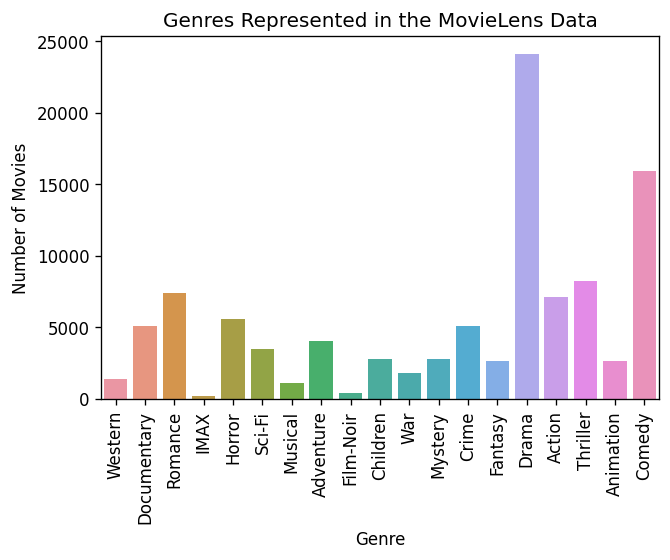

In [11]:
fig = plt.figure(dpi=120)
ax = sns.barplot(x=genres_occurences["Genre"], y=genres_occurences["Occurences"])

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
_ = ax.set(title="Genres Represented in the MovieLens Data", ylabel="Number of Movies")

I would also like to explore the mean rating per genre. Again, a movie can be counted several times if it consists of several genres.

In [65]:
mean_ratings = pd.DataFrame(ratings["rating"].groupby(ratings["movieId"]).mean()).reset_index() # Calculates mean rating for each movie
mean_ratings = mean_ratings.merge(movies, how="left", on="movieId") # Add title and genre 
means = [] # List to save the mean values for each genre

for genre in unique_genres: # Loops through the unique genres from above
    temp = pd.DataFrame({"movieId":mean_ratings["movieId"], 
                        "Mean_rating":mean_ratings["rating"],
                        "Contains_value":mean_ratings["genres"].str.contains(genre)}) #Check if the string contains the genre or not

    temp = pd.DataFrame(temp["Mean_rating"].groupby(temp["Contains_value"]).mean().reset_index()) # Return the mean rating, based on the specific genre (value is True)
    
    means.append(temp["Mean_rating"][1]) # [1] is the second row in the dataframe, Contains_value is True

genres_rating = pd.DataFrame({"Genre":unique_genres, "Mean Rating":means})
genres_rating

,Genre,Mean Rating
0,Comedy,3.051817
1,Sci-Fi,2.769681
2,Crime,3.084298
3,Mystery,3.039553
4,Action,2.910727
5,Documentary,3.403955
6,Film-Noir,3.313832
7,Fantasy,3.035745
8,Western,3.022282
9,War,3.238589


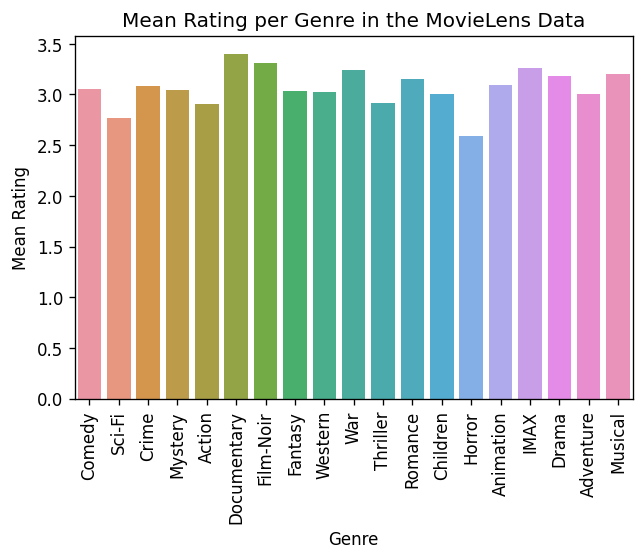

In [66]:
fig = plt.figure(dpi=120)
ax = sns.barplot(x=genres_rating["Genre"], y=genres_rating["Mean Rating"])

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
_ = ax.set(title="Mean Rating per Genre in the MovieLens Data")

b) Vilka är de 10 filmerna med flest ratings?

In [4]:
most_ratings = ratings["rating"].groupby(ratings["movieId"]).count()
most_ratings = pd.DataFrame(most_ratings.sort_values(ascending=False).head(10)).reset_index()
most_ratings = most_ratings.rename({"rating":"Number of Ratings"}, axis=1)
most_ratings

,movieId,Number of Ratings
0,318,97999
1,356,97040
2,296,92406
3,593,87899
4,2571,84545
5,260,81815
6,480,76451
7,527,71516
8,110,68803
9,1,68469


In [5]:
movies_most_ratings = pd.merge(most_ratings, 
                            movies.loc[movies["movieId"].isin(most_ratings["movieId"])], 
                            on="movieId"
                            )
movies_most_ratings

,movieId,Number of Ratings,title,genres
0,318,97999,"Shawshank Redemption, The (1994)",Crime|Drama
1,356,97040,Forrest Gump (1994),Comedy|Drama|Romance|War
2,296,92406,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,593,87899,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,2571,84545,"Matrix, The (1999)",Action|Sci-Fi|Thriller
5,260,81815,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
6,480,76451,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
7,527,71516,Schindler's List (1993),Drama|War
8,110,68803,Braveheart (1995),Action|Drama|War
9,1,68469,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


c) Beräkna den genomsnittliga ratingen för dessa 10 filmerna med flest ratings.

In [12]:
rating_of_most_rated = ratings.loc[ratings["movieId"].isin(most_ratings["movieId"])]
rating_of_most_rated = rating_of_most_rated["rating"].groupby(rating_of_most_rated["movieId"]).mean()

In [13]:
movies_most_rated = pd.merge(movies_most_ratings, 
                            pd.DataFrame({"Mean Rating":rating_of_most_rated}).reset_index(), 
                            on="movieId")
movies_most_rated

,movieId,Number of Ratings,title,genres,Mean Rating
0,318,97999,"Shawshank Redemption, The (1994)",Crime|Drama,4.424188
1,356,97040,Forrest Gump (1994),Comedy|Drama|Romance|War,4.056585
2,296,92406,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.173971
3,593,87899,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.151412
4,2571,84545,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.149695
5,260,81815,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.120455
6,480,76451,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.665034
7,527,71516,Schindler's List (1993),Drama|War,4.257502
8,110,68803,Braveheart (1995),Action|Drama|War,4.008481
9,1,68469,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.886649


d) Gör en plot över årtal och antalet filmer representerade i datasettet.

In [14]:
year_of_movies = movies["title"].str.extract(r"(\(\d{4}\))") # Extract all years in the format (dddd)
year_of_movies = year_of_movies[0].str.extract(r"(\d{4})").rename({0:"Year"}, axis=1) # Removes the parantheses
year_of_movies = pd.DataFrame(year_of_movies["Year"].dropna().astype(int))
year_of_movies

,Year
0,1995
1,1995
2,1995
3,1995
4,1995
...,...
58093,1946
58094,2011
58095,2016
58096,2017


In [15]:
movies_per_year = pd.DataFrame(year_of_movies["Year"].value_counts()).rename({"Year":"Count"}, axis=1)
movies_per_year = movies_per_year.drop(2018) # Remove 2018, since the data is insufficient for this year (dataset was updated 9/2018)
movies_per_year

,Count
2015,2312
2014,2297
2016,2219
2013,2187
2012,2019
...,...
1887,1
1878,1
1874,1
1893,1


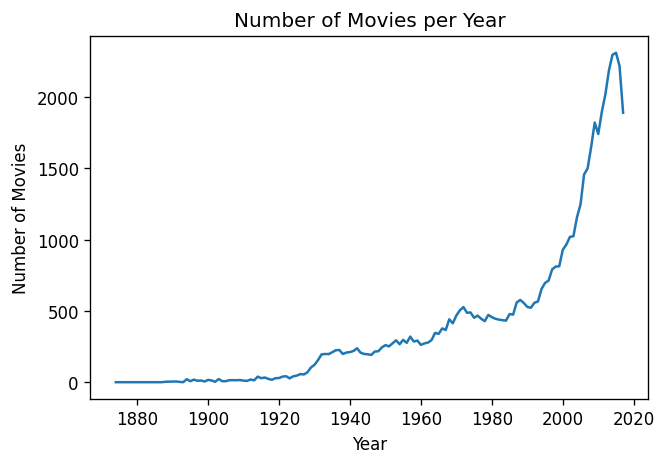

In [16]:
fig = plt.figure(dpi=120)
ax = sns.lineplot(x=movies_per_year.index, y=movies_per_year["Count"])
_ = ax.set(title="Number of Movies per Year", xlabel="Year", ylabel="Number of Movies")

In [17]:
movies.loc[movies["title"].str.contains("1874", case=False)]

,movieId,title,genres
37886,148054,Passage de Venus (1874),Documentary


e) Gör en plot över antalet ratings mot movieId.

In [12]:
ratings_per_movieId = pd.DataFrame(ratings["rating"].groupby(ratings["movieId"]).count()).reset_index()
ratings_per_movieId

,movieId,rating
0,1,68469
1,2,27143
2,3,15585
3,4,2989
4,5,15474
...,...,...
53884,193876,1
53885,193878,1
53886,193880,1
53887,193882,1


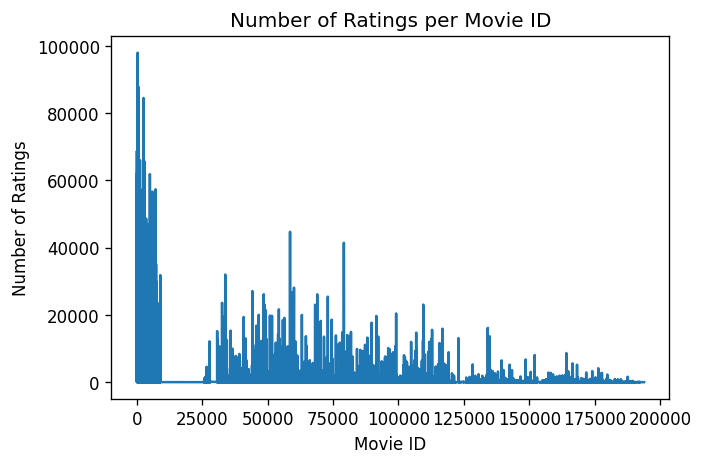

In [17]:
fig = plt.figure(dpi=120)
ax = sns.lineplot(x=ratings_per_movieId["movieId"], y=ratings_per_movieId["rating"])
_ = ax.set(title="Number of Ratings per Movie ID", xlabel="Movie ID", ylabel="Number of Ratings")

f) Beräkna genomsnittliga ratings för de top 10 filmerna med flest ratings. Gör ett stapeldiagram över
dessa.

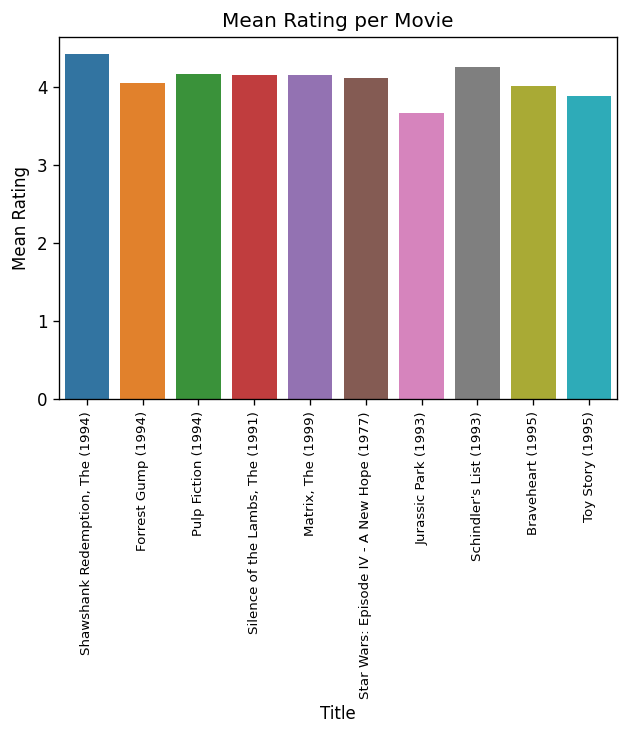

In [21]:
fig = plt.figure(dpi=120)
ax = sns.barplot(x=movies_most_rated["title"], y=movies_most_rated["Mean Rating"])
ax.set(title="Mean Rating per Movie", xlabel="Title")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=8)

### 1.2 Skapa gles matris
Likt i videon i uppgift 1.0 skapade du en pivottabell av dataframet med index "movieId", columns "userId"
och values "ratings". Denna pivottabell är dock "dyrt" att skapa och förmodligen kommer inte din dator att
klara av skapa den om du inte filtrerar bort viss data. Fundera ut ett lämpligt sätt att filtrera ditt dataset,
prova dig fram och motivera.
Skapa en gles (sparse) matris med hjälp av denna pivottabell.

In [4]:
ratings = ratings.drop("timestamp", axis=1) # Drops the timestamp column
ratings

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5
...,...,...,...
27753439,283228,8542,4.5
27753440,283228,8712,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


In [5]:
# Calculates the number of ratings per movie
number_of_ratings = pd.DataFrame(ratings["rating"].groupby(ratings["movieId"]).count())
number_of_ratings["rating"].describe()

count    53889.000000
mean       515.011301
std       2934.758939
min          1.000000
25%          2.000000
50%          7.000000
75%         48.000000
max      97999.000000
Name: rating, dtype: float64

75 % of the movies have a mean rating under 48. I choose to base my decision on the median, rather than the mean, since the data seems to be skewed with some very popular movies that increases the mean. I therefore drop all movies that have been rated 48 or fewer times. It does not seem reasonable to recommend a movie based on very few recommendations (since then one rating of 5 would give it a top mean rating). I also considered basing this rating on 7 (50%), but this still seems a bit too low, and would still introduce uncertainty in the mean rating. I believe 48 is still low enough to capture a variety of movies. 

In [6]:
few_ratings = number_of_ratings[number_of_ratings["rating"] <= 48]

reduced_ratings = ratings[~ratings['movieId'].isin(few_ratings.index)]
reduced_ratings

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5
...,...,...,...
27753439,283228,8542,4.5
27753440,283228,8712,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


This reduced the number of rows from 27,753,444 to 27,435,354, which is still not low enough for pivot to work. I therefore continue to check the mean ratings for the movies, since I do not want to recommend "bad movies".

In [7]:
# Calculates the mean ratings for movies
mean_ratings = pd.DataFrame(reduced_ratings["rating"].groupby(reduced_ratings["movieId"]).mean())
mean_ratings["rating"].describe()

count    13454.000000
mean         3.276252
std          0.485519
min          0.873950
25%          2.991304
50%          3.345979
75%          3.637393
max          4.486518
Name: rating, dtype: float64

I would not like the recommendation system to recommend very "bad movies" and I therefore decide to remove around 25% of the movies, with the lowest mean ratings. 

In [8]:
low_ratings = mean_ratings[mean_ratings["rating"] < 3]

reduced_ratings = reduced_ratings[~reduced_ratings['movieId'].isin(low_ratings.index)]
reduced_ratings

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
3,1,1257,4.5
4,1,1449,4.5
7,1,2134,4.5
...,...,...,...
27753439,283228,8542,4.5
27753440,283228,8712,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


This reduced the number of rows from 27,435,354 to 23,888,004 which is still not low enough for pivot to work. One effective way to remove the last rows for it to work is to remove users with few ratings. 

In [9]:
users_with_few_ratings = pd.DataFrame(ratings["movieId"].groupby(ratings["userId"]).count())
users_with_few_ratings["movieId"].describe()
# Somewhat noteworthy is that there is a user who has given 23715 ratings.

count    283228.000000
mean         97.989761
std         212.760722
min           1.000000
25%          15.000000
50%          30.000000
75%          95.000000
max       23715.000000
Name: movieId, dtype: float64

In [10]:
users_with_few_ratings = users_with_few_ratings[users_with_few_ratings["movieId"] <= 15]

reduced_ratings = reduced_ratings[~reduced_ratings['movieId'].isin(users_with_few_ratings.index)]
reduced_ratings

,userId,movieId,rating
1,1,481,3.5
3,1,1257,4.5
7,1,2134,4.5
8,1,2478,4.0
9,1,2840,3.0
...,...,...,...
27753437,283228,7834,5.0
27753438,283228,8228,5.0
27753439,283228,8542,4.5
27753440,283228,8712,4.5


I also change the datatype so that the data should take less memory. 

In [21]:
print(ratings["userId"].max())
print(ratings["userId"].min())
print(ratings["movieId"].max())
print(ratings["movieId"].min())

283228
1
193886
1


In [22]:
reduced_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17174637 entries, 1 to 27753441
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 524.1 MB


In [11]:
reduced_ratings = reduced_ratings.astype({"userId": np.int32, "movieId": np.int32, "rating": np.float32})

In [12]:
reduced_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17174637 entries, 1 to 27753441
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 327.6 MB


In [13]:
# Run pivot on the reduced data
movies_users = reduced_ratings.pivot(index="movieId", columns="userId", values="rating").fillna(0)

In [14]:
movies_users

userId,1,2,3,4,5,6,7,8,9,10,...,283219,283220,283221,283222,283223,283224,283225,283226,283227,283228
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
5,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
# Creates sparse dataset
movies_users_sparse = csr_matrix(movies_users.values)
print(movies_users_sparse)

In [90]:
# Reset index for the pivoted data, so that movieId can be reached
movies_users = movies_users.reset_index()
movies_users

userId,movieId,1,2,3,4,5,6,7,8,9,...,283219,283220,283221,283222,283223,283224,283225,283226,283227,283228
0,1,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
1,5,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7120,189783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7121,189873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7122,190089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7123,191351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Reduce the movie data so that the movies and indexes are the same as in the pivoted data
movies_reduced = movies.loc[movies["movieId"].isin(reduced_ratings["movieId"])].reset_index(drop=True)
movies_reduced

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,Father of the Bride Part II (1995),Comedy
2,6,Heat (1995),Action|Crime|Thriller
3,8,Tom and Huck (1995),Adventure|Children
4,10,GoldenEye (1995),Action|Adventure|Thriller
...,...,...,...
7120,189783,Christopher Robin (2018),Adventure|Animation|Comedy
7121,189873,Bao (2018),Animation
7122,190089,Hannah Gadsby: Nanette (2018),Comedy
7123,191351,To All the Boys I've Loved Before (2018),Comedy|Romance


In [20]:
model_knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=20) #move this to inside the function

### 1.3 Rekommenderarsystemet
Skapa rekommenderarsystemet med KNN och låt systemet ta input från användaren och skriva ut top 5
rekommenderade filmerna, baserat på användarens sökquery. Notera att det inte gör något för den här
labben om du tycker rekommendationerna är helt felaktiga, det här systemet vi bygger är alldeles för enkelt.

a) Beskriv med ord hur ditt system fungerar.

In [132]:
def recommender(movie_name, data, model, n_recommendations):
    
    model.fit(data)
    
    index_of_input = process.extractOne(movie_name, movies_reduced["title"])[2] # Extracts the index for the movie name inputed
    
    print(f"Movie Selected: {movies_reduced['title'][index_of_input]} \n")
    print(f"Searching for recommendations ... \n")
    print(f"The following {n_recommendations} movies are similar to {movies_reduced['title'][index_of_input]}:")
    
    indexes_recommended = model.kneighbors(data[index_of_input], n_neighbors=(n_recommendations+1), return_distance=False) # data[index_pivot] gives all of the recommendations for that row in the pivot table

    for index in indexes_recommended[0]:
        movieId = movies_reduced["movieId"].iloc[index] # Picks out the movieId for the indexes of the nearest neighbors
        index_of_rec_movie = movies_reduced.index[movies_reduced["movieId"] == movieId][0] # Picks out the index for the movie in the movies data
        
        if index_of_input != index_of_rec_movie:
            print(movies_reduced["title"][index_of_rec_movie])


In [133]:
movie_name = input("Please enter a name of a movie, in order to get recommendations:")
recommender(movie_name, movies_users_sparse, model_knn, 5)

Movie Selected: Star Wars: Episode VI - Return of the Jedi (1983) 

Searching for recommendations ... 

The following 5 movies are similar to Star Wars: Episode VI - Return of the Jedi (1983):
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Indiana Jones and the Last Crusade (1989)
Back to the Future (1985)
Terminator, The (1984)
Matrix, The (1999)


The system works ...

In [125]:
recommender("toy story", movies_users_sparse, model_knn, 10)

Movie Selected: Toy Story (1995) 

Searching for recommendations ... 

The following 10 movies are similar to toy story:
Independence Day (a.k.a. ID4) (1996)
Toy Story 2 (1999)
Back to the Future (1985)
Jurassic Park (1993)
Forrest Gump (1994)
Mission: Impossible (1996)
Star Wars: Episode VI - Return of the Jedi (1983)
Willy Wonka & the Chocolate Factory (1971)
Men in Black (a.k.a. MIB) (1997)
Groundhog Day (1993)


In [134]:
recommender("how to lose a guy in 10 days", movies_users_sparse, model_knn, 10)

Movie Selected: How to Lose a Guy in 10 Days (2003) 

Searching for recommendations ... 

The following 10 movies are similar to How to Lose a Guy in 10 Days (2003):
Sweet Home Alabama (2002)
Two Weeks Notice (2002)
13 Going on 30 (2004)
Legally Blonde (2001)
Princess Diaries, The (2001)
Miss Congeniality (2000)
50 First Dates (2004)
Hitch (2005)
Serendipity (2001)
Proposal, The (2009)


In [135]:
recommender("the fellowship of the ring", movies_users_sparse, model_knn, 10)

Movie Selected: Lord of the Rings: The Fellowship of the Ring, The (2001) 

Searching for recommendations ... 

The following 10 movies are similar to Lord of the Rings: The Fellowship of the Ring, The (2001):
Lord of the Rings: The Two Towers, The (2002)
Lord of the Rings: The Return of the King, The (2003)
Matrix, The (1999)
Pirates of the Caribbean: The Curse of the Black Pearl (2003)
Shrek (2001)
Finding Nemo (2003)
Batman Begins (2005)
Memento (2000)
Monsters, Inc. (2001)
Ocean's Eleven (2001)


In [141]:
recommender("step brothers", movies_users_sparse, model_knn, 10)

Movie Selected: Step Brothers (2008) 

Searching for recommendations ... 

The following 10 movies are similar to Step Brothers (2008):
Talladega Nights: The Ballad of Ricky Bobby (2006)
Anchorman: The Legend of Ron Burgundy (2004)
Other Guys, The (2010)
Role Models (2008)
Blades of Glory (2007)
Superbad (2007)
Forgetting Sarah Marshall (2008)
I Love You, Man (2009)
This Is the End (2013)
Knocked Up (2007)


b) Leta online och läs vidare om rekommenderarsystem och beskriv kort hur dem fungerar. Glöm inte
källhänvisa.